In [15]:
from typing import List, Dict, Optional
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Model Weights (may take a few minutes)

In [16]:
NUM_DIFFUSION_STEPS = 4
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers import DDIMScheduler, LCMScheduler

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="safety_checker")
stable = AttendAndExcitePipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7",safety_checker=safety_checker, dtype=torch.float32).to(device)
tokenizer = stable.tokenizer
stable.scheduler = LCMScheduler.from_config(stable.scheduler.config)
stable.scheduler.set_timesteps(num_inference_steps=4,
                                 original_inference_steps=50,
                                 device='cuda')
#stable.scheduler.steps_offset = 1

Keyword arguments {'dtype': torch.float32} are not expected by AttendAndExcitePipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You have passed a non-standard module StableDiffusionSafetyChecker(
  (vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
       

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = stable.tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
NUM_DIFFUSION_STEPS = 4
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers import DDIMScheduler, LCMScheduler

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="safety_checker")
stable = AttendAndExcitePipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7",safety_checker=safety_checker).to(device)
tokenizer = stable.tokenizer
stable.scheduler = LCMScheduler.from_config(stable.scheduler.config)
stable.scheduler.set_timesteps(num_inference_steps=4,
                                 original_inference_steps=50,
                                 device='cuda')
#stable.scheduler.steps_offset = 1

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You have passed a non-standard module StableDiffusionSafetyChecker(
  (vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
       

# Pipeline Wrapper

In [18]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0:0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False,
                    sd_2_1: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       sd_2_1=sd_2_1)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [19]:
def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               is_attend_and_excite: bool = True,
                               sd_2_1: bool = True):
    token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None else indices_to_alter
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=run_standard_sd,
                                sd_2_1=sd_2_1)
        images.append(image.resize((256,256)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}


Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5):  2,5


Altering tokens: ['cat', 'frog']
1


  0%|          | 0/4 [00:00<?, ?it/s]

1


  0%|          | 0/4 [00:00<?, ?it/s]

1


  0%|          | 0/4 [00:00<?, ?it/s]

1


  0%|          | 0/4 [00:00<?, ?it/s]

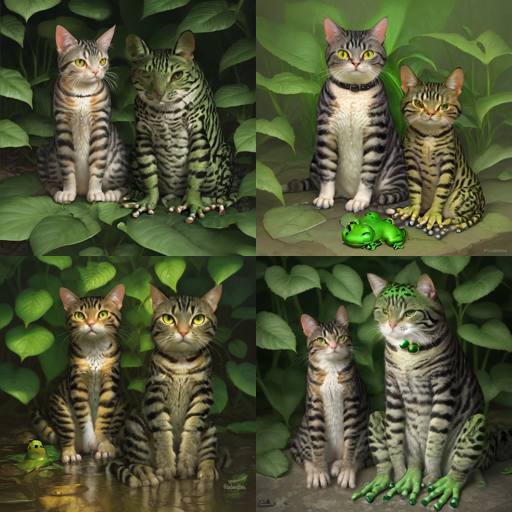

In [20]:
from utils.ptp_utils import AttentionStore

generate_images_for_method(
    prompt= 'A cat and a frog',
    seeds=[10,20,30,40],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog', 6: '.'}


Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5):  2,5


Altering tokens: ['cat', 'frog']


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1836
Iteration 1 | Loss: 0.0012
Iteration 2 | Loss: 0.0091
Iteration 3 | Loss: 0.0152


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0451
Iteration 1 | Loss: 0.0326
Iteration 2 | Loss: 0.0015
Iteration 3 | Loss: 0.0055


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1623
Iteration 1 | Loss: 0.0081
Iteration 2 | Loss: 0.0150
Iteration 3 | Loss: 0.0102


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1032
Iteration 1 | Loss: 0.0711
Iteration 2 | Loss: 0.0176
Iteration 3 | Loss: 0.0411


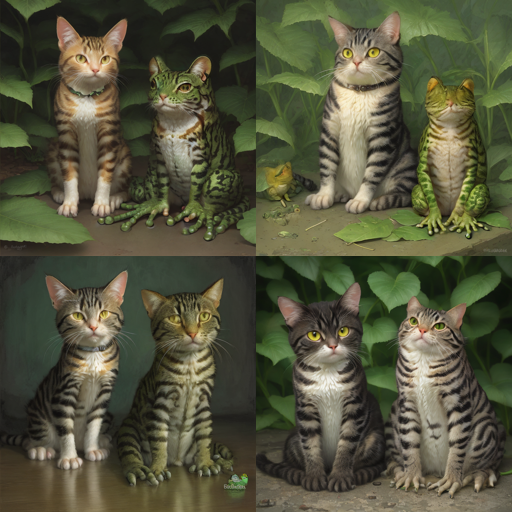

In [9]:
from utils.ptp_utils import AttentionStore

generate_images_for_method(
    prompt= 'A cat and a frog.',
    seeds=[10,20,30,40],
    is_attend_and_excite=True
)

## Stable Diffusion

In [10]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[1,2,3,4],
    is_attend_and_excite=False
)

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}


Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5):  2,6


Altering tokens: ['mouse', 'car']


  0%|          | 0/4 [00:00<?, ?it/s]

KeyError: 'up_cross'

## Attend-and-Excite

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}


Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5):  2,6


Altering tokens: ['mouse', 'car']


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4835
Iteration 1 | Loss: 0.0739
Iteration 2 | Loss: 0.0117
Iteration 3 | Loss: 0.0047


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8024
Iteration 1 | Loss: 0.2712
Iteration 2 | Loss: 0.0111
Iteration 3 | Loss: 0.0016


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.2288
Iteration 1 | Loss: 0.1676
Iteration 2 | Loss: 0.0019
Iteration 3 | Loss: 0.0017


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0249
Iteration 1 | Loss: 0.0004
Iteration 2 | Loss: 0.0023
Iteration 3 | Loss: 0.0022


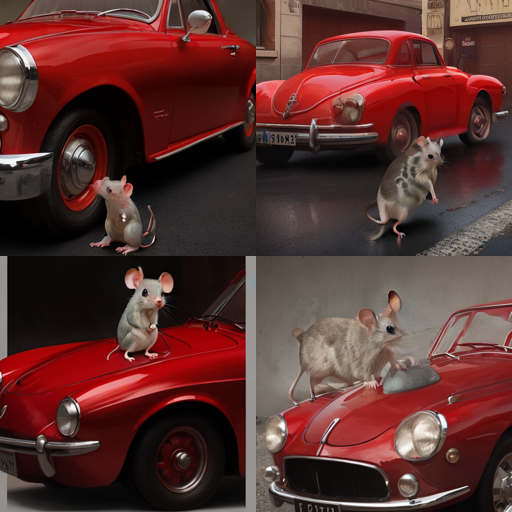

In [17]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[1,2,3,4],
    is_attend_and_excite=True
)

# Stable Diffusion 2.1

In [42]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
tokenizer = stable.tokenizer

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

KeyboardInterrupt: 

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}


Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5):  2,5


Altering tokens: ['cat', 'dog']


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

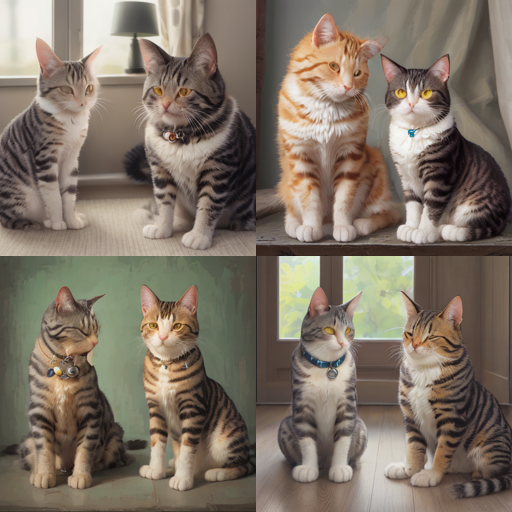

In [6]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=False,
    sd_2_1=True
)

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}


Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5):  2,5


Altering tokens: ['cat', 'dog']


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1833
Iteration 1 | Loss: 0.3369
Iteration 2 | Loss: 0.3779
Iteration 3 | Loss: 0.3749


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3405
Iteration 1 | Loss: 0.1610
Iteration 2 | Loss: 0.3138
Iteration 3 | Loss: 0.2460


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3068
Iteration 1 | Loss: 0.5042
Iteration 2 | Loss: 0.2373
Iteration 3 | Loss: 0.3126


  0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4130
Iteration 1 | Loss: 0.1372
Iteration 2 | Loss: 0.0639
Iteration 3 | Loss: 0.2165


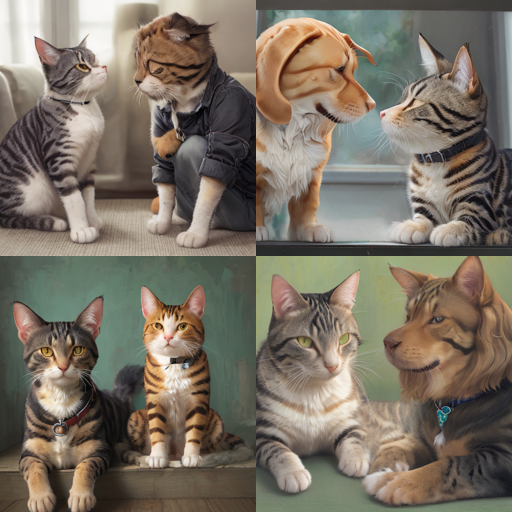

In [7]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=True,
    sd_2_1=True
)